<a href="https://colab.research.google.com/github/AnshSaxena05/Flower_classification/blob/main/Flower_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.Downloading the dataset

In [ ]:
!pip install opendatasets --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import opendatasets as od

In [ ]:
dataset_url = 'https://www.kaggle.com/alxmamaev/flowers-recognition'

In [ ]:
od.download(dataset_url)

100%|██████████| 225M/225M [00:07<00:00, 31.2MB/s]


In [ ]:
data_dir = './flowers-recognition/flowers'

In [ ]:
import os
os.listdir(data_dir)

['sunflower', 'dandelion', 'tulip', 'daisy', 'rose']

In [ ]:
for cls in os.listdir(data_dir):
    print(cls, ':', len(os.listdir(data_dir + '/' + cls)))

sunflower : 733
dandelion : 1052
tulip : 984
daisy : 764
rose : 784


#2.Importing the dataset into pytorch

In [ ]:
from torchvision.datasets import ImageFolder
dataset = ImageFolder(data_dir)
len(dataset)

4317

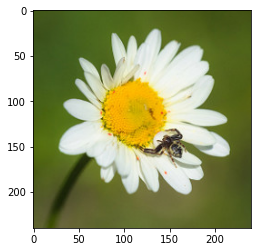

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
img, label = dataset[376]
plt.imshow(img)

In [ ]:
a = dataset[756]  #1:Find the image with the least size in the database and resize accordingly---will help get a more accurate result.
b = dataset[0]
c = dataset[358]
print (a,b,c)

(<PIL.Image.Image image mode=RGB size=240x240 at 0x7FC2591548D0>, 0) (<PIL.Image.Image image mode=RGB size=320x263 at 0x7FC259154290>, 0) (<PIL.Image.Image image mode=RGB size=240x159 at 0x7FC259154650>, 0)


In [ ]:
import torchvision.transforms as tt
dataset = ImageFolder(data_dir, tt.Compose([tt.Resize((64,64)),
                                            tt.RandomCrop((64,64)),
                                            tt.ToTensor()]))

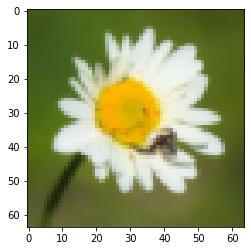

In [ ]:
img, label = dataset[376]
plt.imshow(img.permute((1, 2, 0)))

In [ ]:
val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size
train_size, val_size

(3886, 431)

In [ ]:
from torch.utils.data import random_split
train_ds, valid_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(valid_ds)

(3886, 431)

In [ ]:
from torch.utils.data import DataLoader
batch_size = 128   #2:Gradient Descent Batch size to control the stability
train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=2,  #3:Check the highest number of num_workers the model is stable for and works.
                      pin_memory=True)
valid_dl = DataLoader(valid_ds,
                    batch_size,
                    num_workers=2,
                    pin_memory=True)



"""
 4: Instead of loading the dataset into the cpu and then moving it to the gpu for training (pin_memory),
    load it directly into the gpu.....
"""


'\n 4: Instead of loading the dataset into the cpu and then moving it to the gpu for training (pin_memory),\n    load it directly into the gpu.....\n'

In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(120, 60))
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

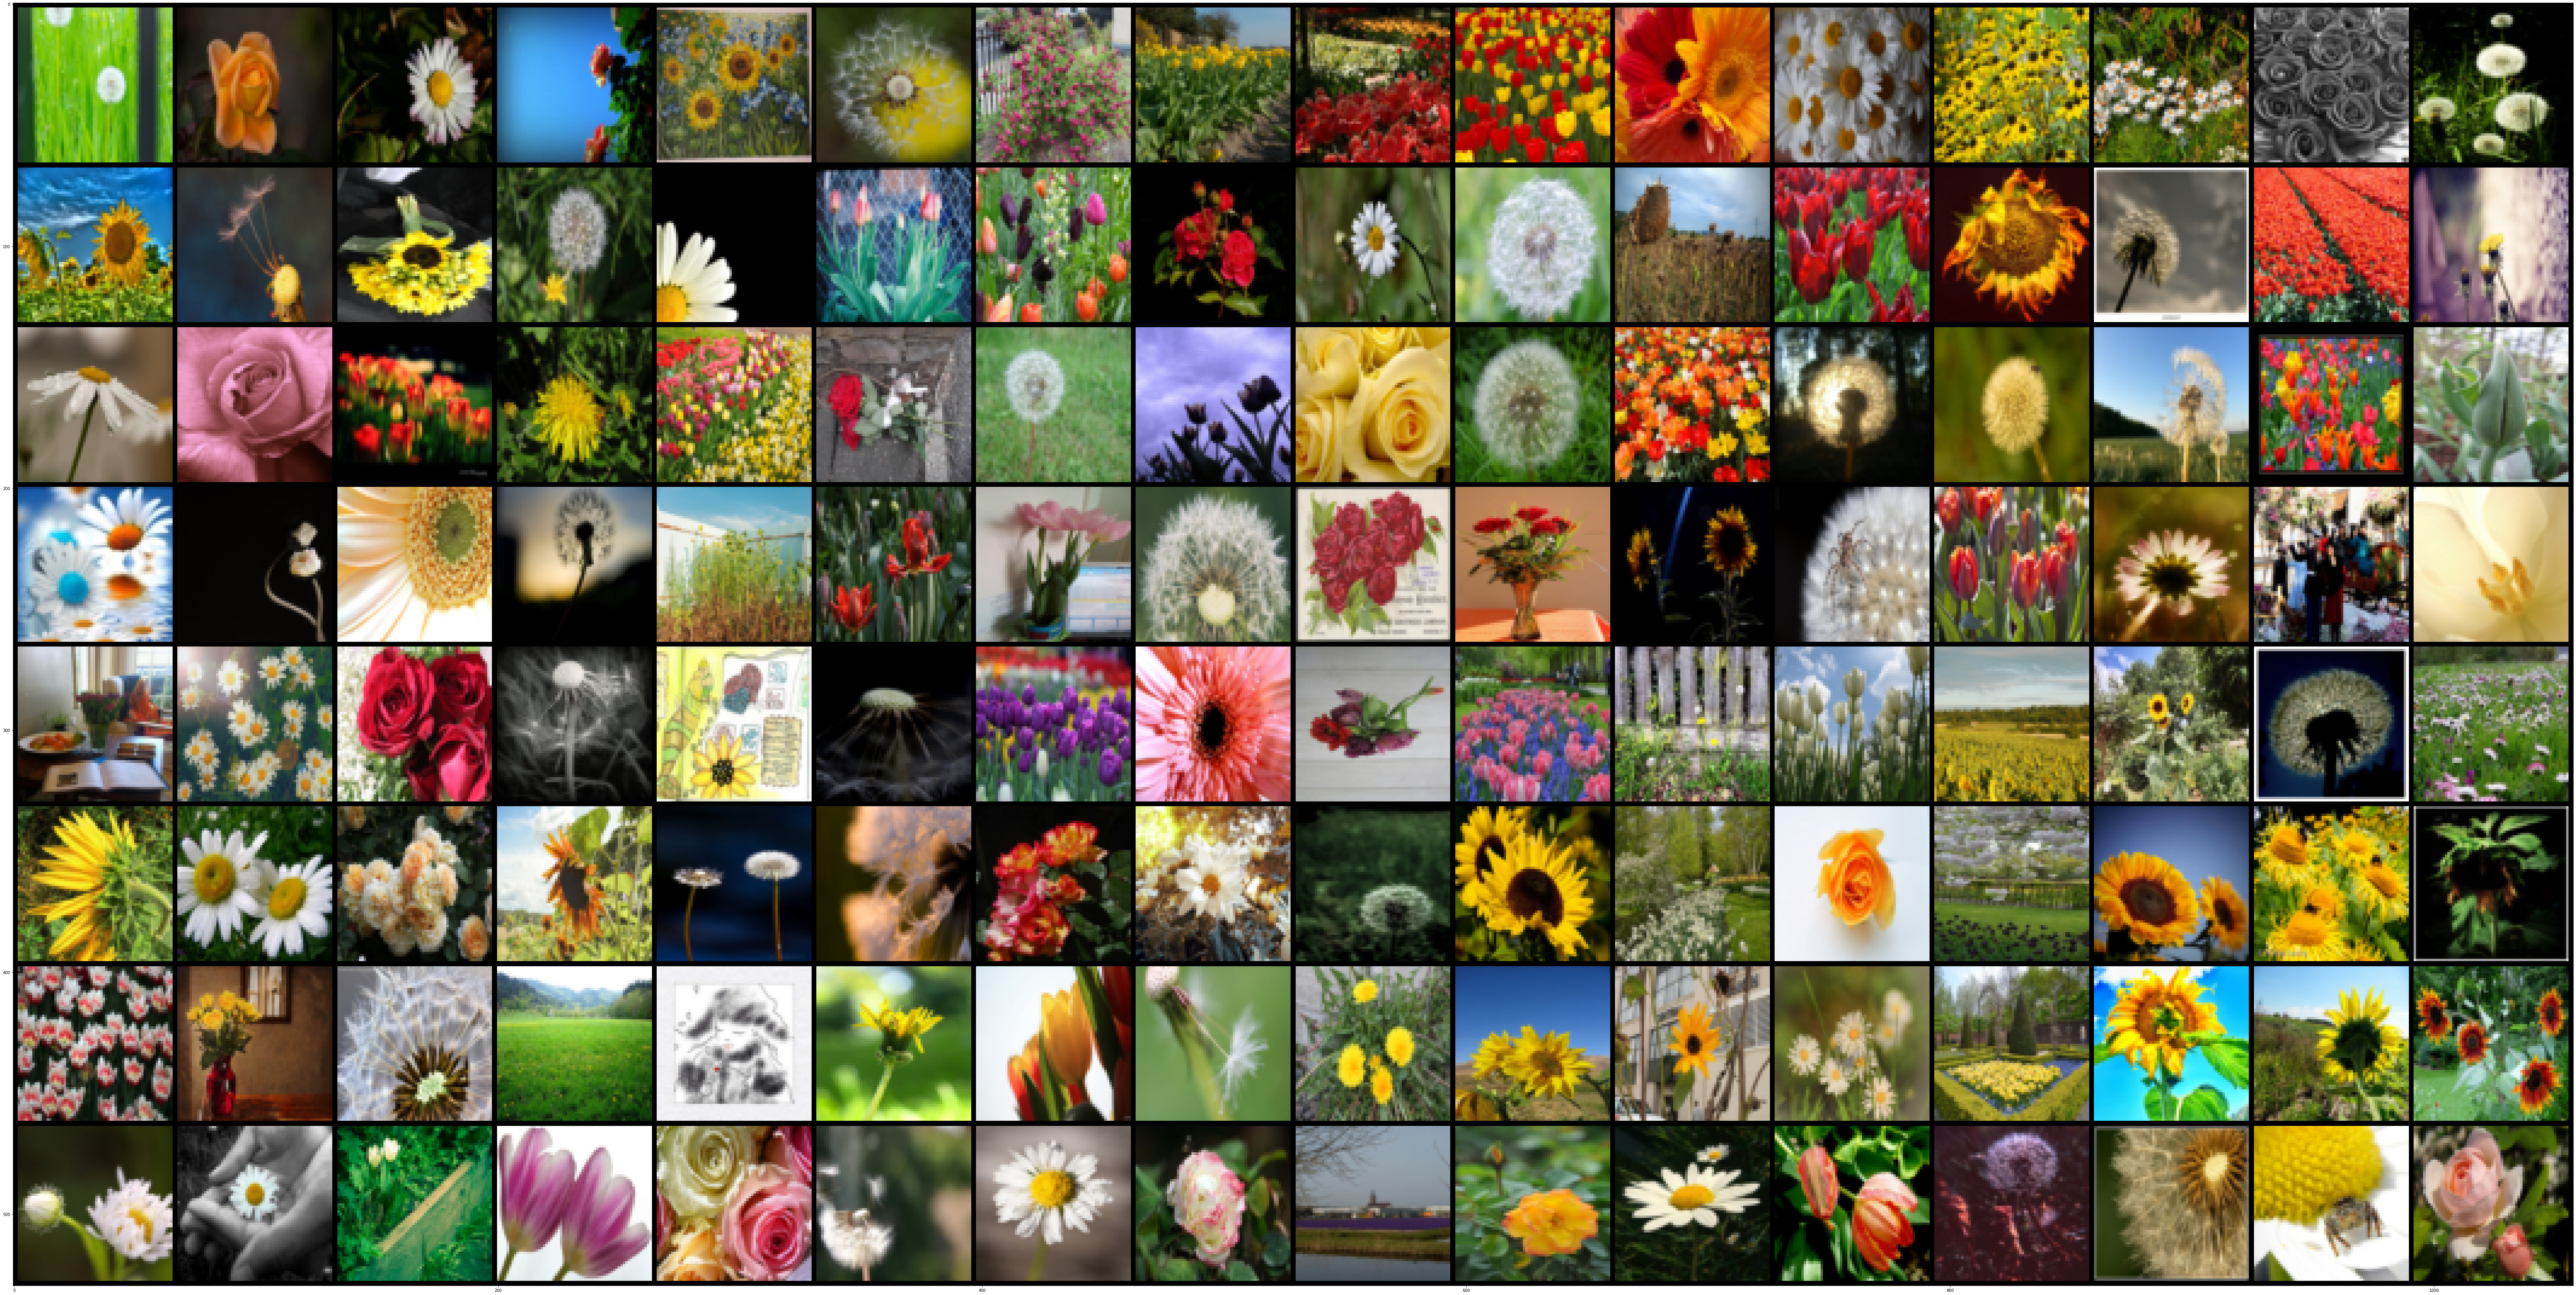

In [ ]:
show_batch(train_dl)

#3.Configuring GPU and training utilities


In [ ]:
import torch

def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = get_default_device()

In [ ]:
device

device(type='cuda')

In [ ]:
img, label = dataset[0]

In [ ]:
img.device

device(type='cpu')

In [ ]:
img_gpu = to_device(img, device)
img_gpu.device

device(type='cuda', index=0)

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)                #5:Try out different loss functions
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    """Evaluates the model's performance on the validation set"""
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

#4.Creating the model


In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128),
                                  conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512),
                                  conv_block(512, 512))

        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1),
                                        nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model = to_device(ResNet9(3, len(dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
model.conv1[0].weight.device

device(type='cuda', index=0)

In [ ]:
torch.cuda.empty_cache()
for batch in train_dl:
    images, labels = batch
    print('images.shape', images.shape)
    print('images.device', images.device)
    preds = model(images)
    print('preds.shape', preds.shape)
    break

images.shape torch.Size([128, 3, 64, 64])
images.device cuda:0
preds.shape torch.Size([128, 5])


#5.Training the model

In [ ]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.6129696369171143, 'val_acc': 0.19522938132286072}]

In [ ]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 1.3968, val_loss: 1.5146, val_acc: 0.3373
Epoch [1], train_loss: 0.8970, val_loss: 0.9444, val_acc: 0.6182
Epoch [2], train_loss: 0.8079, val_loss: 1.1675, val_acc: 0.6580
Epoch [3], train_loss: 0.7574, val_loss: 1.0658, val_acc: 0.6635
Epoch [4], train_loss: 0.6875, val_loss: 0.7548, val_acc: 0.6986


In [ ]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.8582, val_loss: 0.9312, val_acc: 0.6674
Epoch [1], train_loss: 0.6382, val_loss: 0.8424, val_acc: 0.7107
Epoch [2], train_loss: 0.5823, val_loss: 0.8355, val_acc: 0.7009
Epoch [3], train_loss: 0.4904, val_loss: 0.7283, val_acc: 0.7224
Epoch [4], train_loss: 0.4579, val_loss: 0.6743, val_acc: 0.7643


In [ ]:
history += fit(5, 0.0001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.3399, val_loss: 0.4751, val_acc: 0.8216
Epoch [1], train_loss: 0.2840, val_loss: 0.4659, val_acc: 0.8168
Epoch [2], train_loss: 0.2480, val_loss: 0.4735, val_acc: 0.8333
Epoch [3], train_loss: 0.2365, val_loss: 0.4505, val_acc: 0.8255
Epoch [4], train_loss: 0.2206, val_loss: 0.4744, val_acc: 0.8328


In [ ]:
history += fit(5, 0.0001, model, train_dl, valid_dl)

Epoch [0], train_loss: 0.1848, val_loss: 0.4591, val_acc: 0.8347
Epoch [1], train_loss: 0.1861, val_loss: 0.4575, val_acc: 0.8347
Epoch [2], train_loss: 0.1866, val_loss: 0.4618, val_acc: 0.8386
Epoch [3], train_loss: 0.1960, val_loss: 0.4545, val_acc: 0.8386
Epoch [4], train_loss: 0.1954, val_loss: 0.4619, val_acc: 0.8401


In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

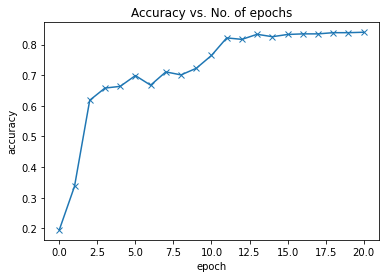

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

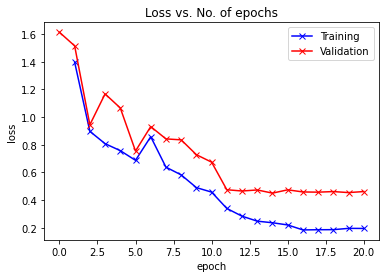

In [ ]:
plot_losses(history)

In [ ]:
history[-1]

{'val_loss': 0.46194151043891907,
 'val_acc': 0.840051531791687,
 'train_loss': 0.195379838347435}

#6.Testing the model

In [ ]:
def predict_image(img, model, classes):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return classes[preds[0].item()]

In [ ]:
def show_image_prediction(img, label):
    plt.imshow(img.permute((1, 2, 0)))
    pred = predict_image(img, model, dataset.classes)
    print('Target:', dataset.classes[label])
    print('Prediction:', pred)

Target: daisy
Prediction: daisy


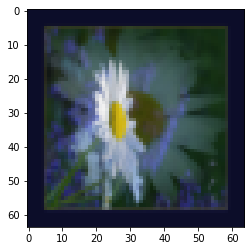

In [ ]:
show_image_prediction(*valid_ds[378])

Target: daisy
Prediction: daisy


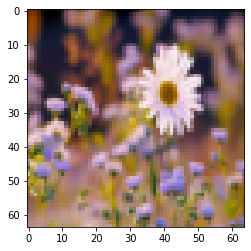

In [ ]:
show_image_prediction(*valid_ds[65])

Target: dandelion
Prediction: dandelion


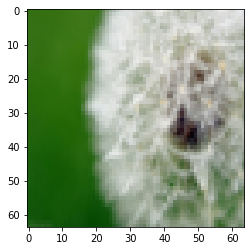

In [ ]:
show_image_prediction(*valid_ds[152])

In [ ]:
torch.save(model.state_dict(), 'flowers-resnet9.pth')